In [1]:
%matplotlib inline
import scipy as sp
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection

In [127]:
n = 10
Xtest = np.linspace(-5,5,n).reshape(-1,1) 
# reshape(-1,1) casts into a column vector basically
a = Xtest

In [128]:
# def kernel(a,b,param):
#     sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1).reshape(-1,1)- 2*np.dot(a,b.T)            
#     return np.exp(-5.*(1/param)*sqdist)
        
def kernel(a, b, param):
    # RBF kernel function
    # same as 
    #     np.exp(-0.5*(1/param)*sp.spatial.distance.squareform(sp.spatial.distance.pdist(a, metric='sqeuclidean')))

    # (a-b)**2 = a**2 + b**2 - 2*a*b OMG MATH? how tf does this work out?
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)

In [129]:
# wow numpy add automatically broadcasts the vectors into rectangles
# when the shapes are mismatched. 
np.array([0,1,2]) + np.array([10,20,30]).reshape(-1,1)

array([[10, 11, 12],
       [20, 21, 22],
       [30, 31, 32]])

(10, 10)


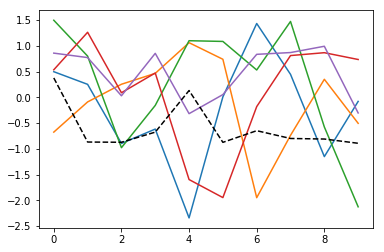

In [130]:
K_ss = kernel(a,a,1) + 1e-14*np.eye(n)
L = np.linalg.cholesky(K_ss)
print(L.shape)
norm_draws = np.random.normal(size=(n,5));
#plt.plot(norm_draws)
plt.plot(np.dot(L, norm_draws))

# same thing as doing
plt.plot(np.random.multivariate_normal(np.zeros(n),K), '--k')

### priors on f

- get a covariance (kernel) matrix that, more or less, constrains smoothness, since each dimension (time point) is correlated with its neighbors. RBF is one such function.

- use that covariance matrix and generate random gaussian samples following it, which means the samples follow the smoothness constraint

- using the cholesky decomposition with uncorrelated gaussian random draws, apparently, is computationally advantageous to simulating the correlated gaussians. np/sp probably uses this trick to simulate the multivariate gaussian anyway.

(https://en.wikipedia.org/wiki/Cholesky_decomposition#Monte_Carlo_simulation) 

### training

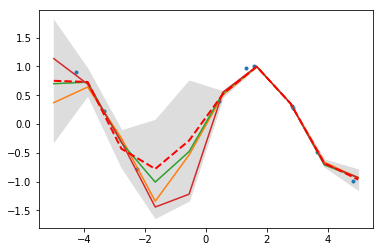

In [160]:
xtrain = 10*np.random.rand(10).reshape(-1,1)-5
ytrain = np.sin(xtrain)
plt.plot(xtrain, ytrain, '.')

# training
K = kernel(xtrain, xtrain, 1)
L = np.linalg.cholesky(K+1e-10*np.eye(len(xtrain)))

# norm_draws = np.random.normal(size=(len(xtrain),5))
# plt.plot(np.dot(L, norm_draws))

# WHATS HAPPENING HERE?? ----------
K_s = kernel(xtrain, a, 1)
Lk = np.linalg.solve(L, K_s)
mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape(n,)

s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)

L = np.linalg.cholesky(K_ss - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,3)))
#-----------------------

plt.plot(a, f_post)
plt.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
plt.plot(Xtest, mu, 'r--', lw=2)